In [2]:
import importlib
import math
import time

import numpy as np
import pandas as pd

import skimage
from skimage.io import imread
from skimage import color
from skimage.transform import rescale, resize, downscale_local_mean

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d
from torch.optim import Adam
from torch.utils import data

import natural_images_dataset_loader
from natural_images_dataset_loader import get_class_label_map, NaturalImagesDataset

In [3]:
importlib.reload(natural_images_dataset_loader)
from natural_images_dataset_loader import get_class_label_map, NaturalImagesDataset

In [4]:
%matplotlib inline

In [5]:
class NaturalImagesNet(nn.Module):
    
    def __init__(self, in_channels, classes_num):
        super(NaturalImagesNet, self).__init__()
        self.in_channels = in_channels
        self.conv0 = Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, stride=1, padding=0)
        self.fc_out = Linear(62 * 62 * in_channels, classes_num)
        
    def forward(self, x):
        #print("forward: x.shape before conv0(x)", x.shape)
        x = self.conv0(x)
        #print("forward: x.shape after conv0(x)", x.shape)
        x = x.view(-1, 62 * 62 * self.in_channels)
        x = self.fc_out(x)
        #x = F.log_softmax(x, dim=1)
        x = F.log_softmax(x)
        #print("forward, x after log_softmax:\n", x)
        return x

In [6]:
params = {'batch_size': 4, 'shuffle': True}
class_label_map = get_class_label_map('../input/natural-images/natural_images/*')

ni_ds_train = NaturalImagesDataset(class_label_map, resize_sizes=(64, 64))
ni_train_dataloader = data.DataLoader(ni_ds_train, **params)

ni_ds_valid = NaturalImagesDataset(class_label_map, valid=True, resize_sizes=(64, 64))
ni_valid_loader = data.DataLoader(ni_ds_valid, **params)

In [7]:
classes_num = len(class_label_map)

In [8]:
input_channels = 3

In [9]:
learning_rate = 0.001

In [10]:
#img, label = next(iter(ni_train_dataloader))

In [11]:
#type(img)
#img.shape

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
print("device: ", device)

device:  cuda:0


In [14]:
model = NaturalImagesNet(input_channels, classes_num)
#model = NaturalImagesNet()

In [15]:
model.to(device)

NaturalImagesNet(
  (conv0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (fc_out): Linear(in_features=11532, out_features=8, bias=True)
)

In [16]:
criterion = CrossEntropyLoss()

In [17]:
optimizer = Adam(model.parameters(), lr=learning_rate)

In [18]:
num_of_epoch = 12

train_losses = []
val_losses = []

start_time = time.time()

for epoch in range(num_of_epoch):
    # loop over the dataset multiple times
    
    avg_train_cost = 0
    avg_val_cost = 0
    
    train_running_loss = 0.0
    val_running_loss = 0.0
    
    for i, data in enumerate(ni_train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        
        train_losses.append(loss)
        
        loss.backward()
        optimizer.step()

        # print statistics
        train_running_loss += loss.item()
        
        if i % 200 == 199:    # print every 2000 mini-batches
            print("epoch: {}, batch: {} train running loss: {}".format(epoch, i, train_running_loss / 20))
            train_running_loss = 0.0
            
        avg_train_cost = avg_train_cost + loss.data
                
    if epoch % 2 != 0:
        print("epoch {}, avg train cost: {}".format(epoch, avg_train_cost))
        avg_train_cost = 0
        
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(ni_valid_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
                
            outputs = model(inputs)
                
            val_loss = criterion(outputs, labels)
            val_losses.append(val_loss)
                
            val_running_loss += val_loss.item()
                
            if i % 200 == 199:    # print every 2000 mini-batches
                print("epoch: {}, batch: {} val running loss: {}".format(epoch, i, val_running_loss / 20))
                val_running_loss = 0.0
                
        avg_val_cost = avg_val_cost + loss.data
                
        if epoch % 2 != 0:
            print("epoch {}, avg val cost: {}".format(epoch, avg_val_cost))
            avg_val_cost = 0



print('Finished Training')
time_elapsed = time.time() - start_time
print(
    'Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60
    )
)

epoch: 0, batch: 199 train running loss: 13.018030294030904
epoch: 0, batch: 399 train running loss: 9.668589228577911
epoch: 0, batch: 599 train running loss: 9.097947082668544
epoch: 0, batch: 799 train running loss: 8.742700273543596
epoch: 0, batch: 999 train running loss: 8.99667785060592
epoch: 0, batch: 1199 train running loss: 8.521547665516845
epoch: 0, batch: 199 val running loss: 8.689105697558261
epoch: 0, batch: 399 val running loss: 8.707737605599686
epoch: 1, batch: 199 train running loss: 6.162851472490002
epoch: 1, batch: 399 train running loss: 6.1693248702795245
epoch: 1, batch: 599 train running loss: 6.287840422289446
epoch: 1, batch: 799 train running loss: 6.372056180343497
epoch: 1, batch: 999 train running loss: 6.4124604530836224
epoch: 1, batch: 1199 train running loss: 7.5177836692892015
epoch 1, avg train cost: 836.2734985351562
epoch: 1, batch: 199 val running loss: 9.204033853206784
epoch: 1, batch: 399 val running loss: 8.546893475204707
epoch 1, avg val

NameError: name 'since' is not defined

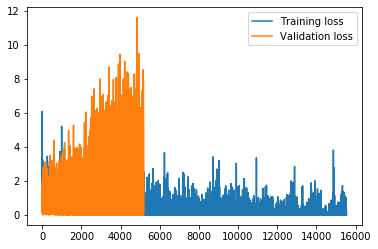

In [19]:
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")#x = self.relu(x)
plt.legend()
plt.show()

In [ ]:
x, y = Variable(train_x), Variable(train_y, requires_grad=False)

pred = model(x)

final_pred = np.argmax(pred.data.numpy(), axis=1)

accuracy_score(train_y, final_pred)

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))